<a href="https://colab.research.google.com/github/kyangleo/STATS-507/blob/main/stats507final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q "transformers>=4.45.0" "datasets>=3.0.0" \
                "accelerate>=1.0.0" "evaluate>=0.4.0" \
                scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

print("PyTorch version", torch.__version__)
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch version 2.9.0+cu126
GPU is available


In [4]:
imdb = load_dataset("imdb")
imdb

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
print(imdb["train"][0]["text"][:500])
print("Label:", imdb["train"][0]["label"])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent
Label: 0


In [6]:
label2str = {0: "negative", 1: "positive"}

In [7]:
# 10% train data for validation
train_valid = imdb["train"].train_test_split(test_size=0.1, seed=SEED)
train_dataset = train_valid["train"]
valid_dataset = train_valid["test"]
test_dataset = imdb["test"]

print(train_dataset)
print(valid_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 22500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [8]:
# EDA
def review_length(text):
  return len(text.split())

lengths = [review_length(text) for text in train_dataset["text"]]

print("Number of training reviews:", len(lengths))
print("Average length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("Min length:", np.min(lengths))
print("Max length:", np.max(lengths))

Number of training reviews: 22500
Average length: 234.39706666666666
Median length: 174.0
Min length: 10
Max length: 2470


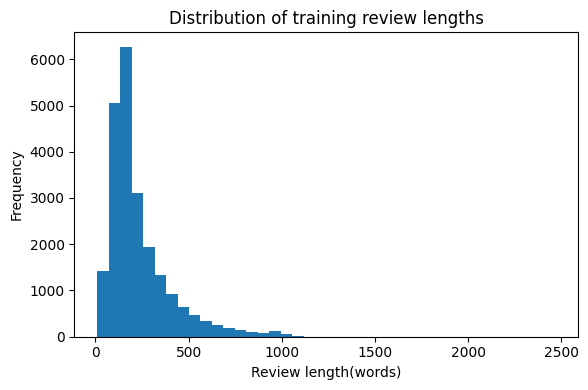

In [9]:
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40)
plt.xlabel("Review length(words)")
plt.ylabel("Frequency")
plt.title("Distribution of training review lengths")
plt.tight_layout()
plt.show()

In [10]:
from collections import Counter

train_label_counts = Counter(train_dataset["label"])
valid_label_counts = Counter(valid_dataset["label"])
test_label_counts = Counter(test_dataset["label"])

print("Training label counts:", train_label_counts)
print("Validation label counts:", valid_label_counts)
print("Test label counts:", test_label_counts)
# The dataset is approximately balanced with 25,000 positive and
# 25,000 negative movie reviews in total.

Training label counts: Counter({0: 11257, 1: 11243})
Validation label counts: Counter({1: 1257, 0: 1243})
Test label counts: Counter({0: 12500, 1: 12500})


In [11]:
# small scale for quick test
small_train = train_dataset.shuffle(SEED).select(range(2000))
small_valid = valid_dataset.shuffle(SEED).select(range(1000))
small_test = test_dataset.shuffle(SEED).select(range(1000))

small_train, small_valid, small_test

(Dataset({
     features: ['text', 'label'],
     num_rows: 2000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }))

In [12]:
USE_SMALL = False

if USE_SMALL:
  dataset_train = small_train
  dataset_valid = small_valid
  dataset_test = small_test
else:
  dataset_train = train_dataset
  dataset_valid = valid_dataset
  dataset_test = test_dataset

len(dataset_train), len(dataset_valid), len(dataset_test)

(22500, 2500, 25000)

In [13]:
X_train = dataset_train["text"]
y_train = dataset_train["label"]

X_valid = dataset_valid["text"]
y_valid = dataset_valid["label"]

X_test = dataset_test["text"]
y_test = dataset_test["label"]

print("Example review:", X_train[0][:300])
print("Example label:", label2str[y_train[0]])

Example review: With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in th
Example label: negative


In [14]:
# TF-IDF + Logistic Regression Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("logreg", LogisticRegression(
        max_iter=200,
        n_jobs=-1,
        C=1.0
    ))
])

baseline_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=200, n_jobs=-1))])

In [16]:
y_valid_pred = baseline_clf.predict(X_valid)

acc_valid = accuracy_score(y_valid, y_valid_pred)
print(f"Validation accuracy (baseline): {acc_valid: .4f}")

print("\nValidation classification report:")
print(classification_report(y_valid, y_valid_pred, target_names=["negative", "positive"]))

Validation accuracy (baseline):  0.8932

Validation classification report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      1243
    positive       0.89      0.90      0.89      1257

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



In [17]:
y_test_pred = baseline_clf.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (baseline): {acc_test: .4f}")

print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, target_names=["negative", "positive"]))

Test accuracy (baseline):  0.8814

Test classification report:
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88     12500
    positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [18]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
cm

array([[11016,  1484],
       [ 1482, 11018]])

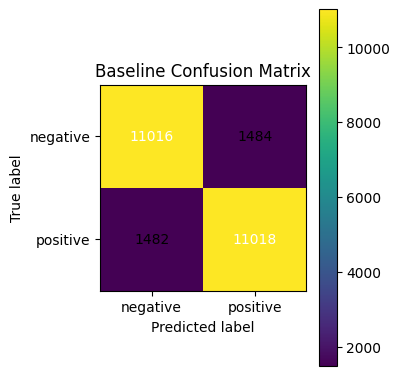

In [19]:
def plot_confusion_matrix(cm, class_names):
  fig, ax = plt.subplots(figsize=(4,4))
  im = ax.imshow(cm, interpolation="nearest")
  plt.colorbar(im)

  ax.set_xticks(np.arange(len(class_names)))
  ax.set_yticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)

  ax.set_xlabel("Predicted label")
  ax.set_ylabel("True label")
  ax.set_title("Baseline Confusion Matrix")

  thresh = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], 'd'),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.show()

plot_confusion_matrix(cm, ["negative", "positive"])

In [20]:
import joblib

os.makedirs("models", exist_ok=True)
joblib.dump(baseline_clf, "models/baseline_tfidf_logreg.joblib")

['models/baseline_tfidf_logreg.joblib']

# DistilBERT Fine-Tuning

In [21]:
USE_SMALL = False

if USE_SMALL:
    dataset_train = small_train
    dataset_valid = small_valid
    dataset_test  = small_test
else:
    dataset_train = train_dataset
    dataset_valid = valid_dataset
    dataset_test  = test_dataset

len(dataset_train), len(dataset_valid), len(dataset_test)


(22500, 2500, 25000)

In [22]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

import numpy as np

In [23]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def tokenize_batch(batch):
  return tokenizer(
      batch["text"],
      padding=False,
      truncation=True,
      max_length=216
  )

tokenized_train = dataset_train.map(tokenize_batch, batched=True)
tokenized_valid = dataset_valid.map(tokenize_batch, batched=True)
tokenized_test = dataset_test.map(tokenize_batch, batched=True)

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  preds = np.argmax(logits, axis=-1)

  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, preds, average="binary"
  )

  return {
      "accuracy": acc,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

In [27]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="distilbert_imdb",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
)

if torch.cuda.is_available():
    training_args.fp16 = True


In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-4034854016.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kaiyangl (kaiyangl-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.275000,0.263952,0.893600,0.916037,0.867940,0.891340
2,0.177900,0.297920,0.903200,0.914286,0.891010,0.902498


TrainOutput(global_step=2814, training_loss=0.24296638627974124, metrics={'train_runtime': 1740.6146, 'train_samples_per_second': 25.853, 'train_steps_per_second': 1.617, 'total_flos': 2514810771360000.0, 'train_loss': 0.24296638627974124, 'epoch': 2.0})

In [29]:
eval_valid = trainer.evaluate(tokenized_valid)
eval_valid

{'eval_loss': 0.29791969060897827,
 'eval_accuracy': 0.9032,
 'eval_precision': 0.9142857142857143,
 'eval_recall': 0.8910103420843277,
 'eval_f1': 0.9024979854955681,
 'eval_runtime': 16.7633,
 'eval_samples_per_second': 149.135,
 'eval_steps_per_second': 4.713,
 'epoch': 2.0}

In [30]:
eval_test = trainer.evaluate(tokenized_test)
eval_test

{'eval_loss': 0.2690802812576294,
 'eval_accuracy': 0.9086,
 'eval_precision': 0.9044903777619387,
 'eval_recall': 0.91368,
 'eval_f1': 0.9090619652166991,
 'eval_runtime': 168.5769,
 'eval_samples_per_second': 148.3,
 'eval_steps_per_second': 4.639,
 'epoch': 2.0}

In [31]:
pred_output = trainer.predict(tokenized_test)
logits = pred_output.predictions
y_test_pred_bert = np.argmax(logits, axis=-1)
y_test_true = np.array(tokenized_test["label"])

from sklearn.metrics import confusion_matrix
cm_bert = confusion_matrix(y_test_true, y_test_pred_bert)
cm_bert

array([[11294,  1206],
       [ 1079, 11421]])

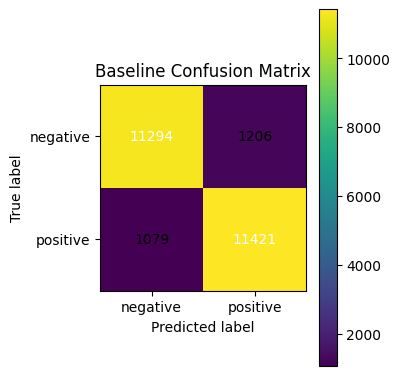

In [32]:
plot_confusion_matrix(cm_bert, ["negative", "positive"])

<Figure size 400x400 with 0 Axes>

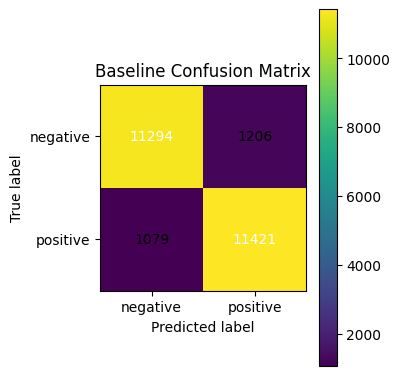

In [33]:
import os
os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm_bert, ["negative", "positive"])
plt.savefig("figures/confusion_distilbert.png", dpi=300, bbox_inches="tight")
plt.close()

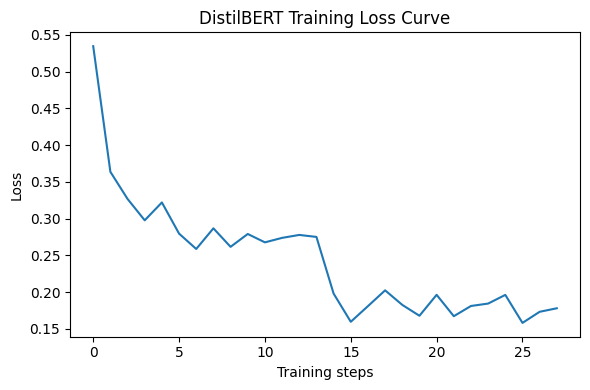

In [34]:
logs = trainer.state.log_history

losses = [log["loss"] for log in logs if "loss" in log]
steps = list(range(len(losses)))

plt.figure(figsize=(6,4))
plt.plot(steps, losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("DistilBERT Training Loss Curve")
plt.tight_layout()
plt.show()

os.makedirs("figures", exist_ok=True)
plt.savefig("figures/training_curve_distilbert.png", dpi=300, bbox_inches="tight")
plt.close()

In [35]:
# Save Model
trainer.save_model("models/distilbert_imdb_finetuned")
tokenizer.save_pretrained("models/distilbert_imdb_finetuned")

('models/distilbert_imdb_finetuned/tokenizer_config.json',
 'models/distilbert_imdb_finetuned/special_tokens_map.json',
 'models/distilbert_imdb_finetuned/vocab.txt',
 'models/distilbert_imdb_finetuned/added_tokens.json',
 'models/distilbert_imdb_finetuned/tokenizer.json')

In [36]:
from transformers import pipeline

sentiment_pipeline = pipeline(
    "text-classification",
    model="models/distilbert_imdb_finetuned",
    tokenizer="models/distilbert_imdb_finetuned",
    device=0 if torch.cuda.is_available() else -1,
)

sentiment_pipeline("This movie is great!")

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9963590502738953}]